Scenarios saved to ../Result/OECD_benchmark_scenarios.csv
Plot saved to ../Result/Plots/OECD_benchmark_scenarios.pdf


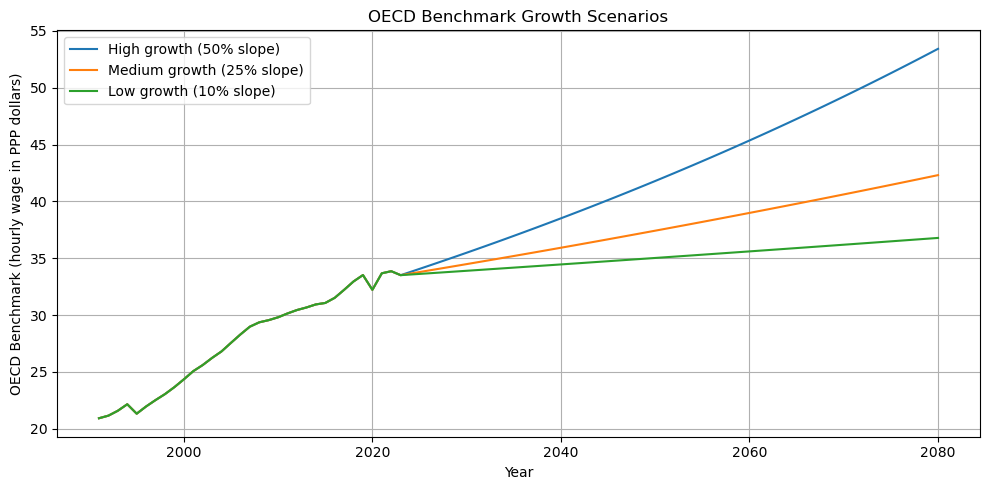

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ================================================
# 1. LOAD & LOG‑TRANSFORM YOUR WAGE DATA
# ================================================
# Optional: define helper if not already done
def get_path(*parts):
    return os.path.join('..', *parts)

# Load the final wage estimates
df = pd.read_csv(get_path('Result', 'Countries_Wages_Estimates_Finals_GOOD.csv'))

df['log_wage'] = np.log(df['estimated_hourly_wage'])

# ================================================
# 2. COMPUTE HISTORICAL OECD BENCHMARK (1991–2023)
# ================================================
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Rep.','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States','Estonia','Korea','Lithuania','Poland'
}

hist = (
    df[df['country'].isin(oecd) & df['year'].between(1991, 2023)]
      .groupby('year')['log_wage']
      .mean()
      .rename('benchmark_log')
      .to_frame()
)

years_hist = hist.index.values            # [1991 … 2023]
loghist    = hist['benchmark_log'].values # log‐benchmark
last_year  = years_hist[-1]
last_log   = loghist[-1]

# ================================================
# 3. FIT HIGH‑GROWTH LINEAR TREND ON LOG
# ================================================
lin_model = LinearRegression().fit(
    years_hist.reshape(-1,1),
    loghist
)
slope_lin     = lin_model.coef_[0]
intercept_lin = lin_model.intercept_

# ================================================
# 4. DEFINE “REALISTIC” HIGH/MEDIUM/LOW SLOPES
#    High = 50% of hist slope (~2% p.a.)
#    Medium = 25% (~1% p.a.)
#    Low = 10% (~0.4% p.a.)
# ================================================
high_slope     = 0.50 * slope_lin
high_intercept = last_log - high_slope * last_year

med_slope      = 0.25 * slope_lin
med_intercept  = last_log - med_slope * last_year

low_slope      = 0.10 * slope_lin
low_intercept  = last_log - low_slope * last_year

# ================================================
# 5. FORECAST 2024–2080
# ================================================
extrap_year = 2080
years_fut   = np.arange(2024, extrap_year+1)

high_log   = high_slope  * years_fut + high_intercept
medium_log = med_slope   * years_fut + med_intercept
low_log    = low_slope    * years_fut + low_intercept

# ================================================
# 6. CONCATENATE & EXPONENTIATE BACK TO LEVELS
# ================================================
years_full      = np.concatenate([years_hist,    years_fut])
bench_high      = np.exp(np.concatenate([loghist,    high_log]))
bench_medium    = np.exp(np.concatenate([loghist,    medium_log]))
bench_low       = np.exp(np.concatenate([loghist,    low_log]))

# ================================================
# 7. BUILD A DATAFRAME & SAVE
# ================================================
bench_df = pd.DataFrame({
    'year':             years_full,
    'benchmark_high':   bench_high,
    'benchmark_medium': bench_medium,
    'benchmark_low':    bench_low,
})

out_csv = get_path('Result', 'OECD_benchmark_scenarios.csv')
bench_df.to_csv(out_csv, index=False)
print(f"Scenarios saved to {out_csv}")

# ================================================
# 8. PLOT THE THREE SCENARIOS
# ================================================
plt.figure(figsize=(10, 5))
plt.plot(bench_df['year'], bench_df['benchmark_high'],   color='C0', label='High growth (50% slope)')
plt.plot(bench_df['year'], bench_df['benchmark_medium'], color='C1', label='Medium growth (25% slope)')
plt.plot(bench_df['year'], bench_df['benchmark_low'],    color='C2', label='Low growth (10% slope)')
plt.xlabel('Year')
plt.ylabel('OECD Benchmark (hourly wage in PPP dollars)')
plt.title('OECD Benchmark Growth Scenarios')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Save the figure too:
out_pdf = get_path('Result', 'Plots', 'OECD_benchmark_scenarios.pdf')
plt.savefig(out_pdf, dpi=300)
print(f"Plot saved to {out_pdf}")

plt.show()


In [3]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

# ── 1. LOAD DATA & OECD SCENARIOS ─────────────────────────────────────────────
df = pd.read_csv(get_path('Result', 'Countries_Wages_Estimates_Finals_GOOD.csv'))

df['log_wage'] = np.log(df['estimated_hourly_wage'])

# normalize df country names
df['country'] = (
    df['country']
      .str.replace('\u00A0', ' ')  # NBSP → normal space
      .str.strip()                 # trim whitespace
)

bench_df = pd.read_csv(get_path('Result', 'OECD_benchmark_scenarios.csv'))

# ── 2. EXCLUDE OECD COUNTRIES & MERGE SCENARIOS ─────────────────────────────────
oecd = {
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Rep.','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States','Estonia','Korea','Lithuania','Poland'
}

# normalize the OECD set the same way
oecd = { name.replace('\u00A0', ' ').strip() for name in oecd }

df2 = (
    df
      .merge(bench_df, on='year', how='left')
      .query("country not in @oecd")
      .dropna(subset=['benchmark_high'])
)

# ── 3. MODEL CANDIDATES & ROLLING-ORIGIN SPLITS ──────────────────────────────────
def exp_decay(tc, A, k, C):
    return A * np.exp(-k*tc) + C

def logistic(tc, L, k, C):
    return C + L / (1 + np.exp(-k*tc))

tscv = TimeSeriesSplit(n_splits=5)

# ── 4. THRESHOLDS & OUTPUT SETUP ───────────────────────────────────────────────
extrap_year = bench_df['year'].max()
thr_levels  = [0.7, 0.8, 0.9]
log_thr     = {lvl: np.log(lvl) for lvl in thr_levels}

results = []

# ── 5. LOOP OVER NON-OECD COUNTRIES & PLOT ──────────────────────────────────────
with PdfPages(get_path('Result', 'Plots', 'V30_convergence_three_scenarios_nonOECD_plateau.pdf')) as pdf:


    for country, sub in df2.groupby('country'):
        sub = sub.sort_values('year')
        if len(sub) < 6:
            continue

        years_hist = sub['year'].values
        t0         = years_hist.min()
        tc_hist    = (years_hist - t0).reshape(-1,1)
        logw_hist  = sub['log_wage'].values

        # a) Rolling-origin CV for candidate models
        candidate_errors = {}
        pipelines = {
            'Linear': LinearRegression(),
            'Quadratic': Pipeline([('poly', PolynomialFeatures(2)),('lr',LinearRegression())]),
            'Sqrt': Pipeline([('sqrt', FunctionTransformer(np.sqrt,validate=False)),('lr',LinearRegression())])
        }
        for name, model in pipelines.items():
            errs = []
            for tr, te in tscv.split(tc_hist):
                model.fit(tc_hist[tr], logw_hist[tr])
                errs.append(mean_squared_error(
                    logw_hist[te], model.predict(tc_hist[te])
                ))
            candidate_errors[name] = np.mean(errs)

        # b) CV for ExpDecay & Logistic
        for name, func in [('ExpDecay', exp_decay), ('Logistic', logistic)]:
            errs = []
            for tr, te in tscv.split(tc_hist):
                Xtr = tc_hist[tr].ravel(); Ytr = logw_hist[tr]
                try:
                    p0 = [Ytr[0]-Ytr[-1],0.02,Ytr[-1]] if name=='ExpDecay' else [Ytr.max()-Ytr.min(),0.1,Ytr.min()]
                    popt, _ = curve_fit(func, Xtr, Ytr, p0=p0,
                                        bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
                    preds = func(tc_hist[te].ravel(), *popt)
                    errs.append(mean_squared_error(logw_hist[te], preds))
                except:
                    errs=[]
                    break
            if errs:
                candidate_errors[name] = np.mean(errs)

        # c) Select & refit best
        best = min(candidate_errors, key=candidate_errors.get)
        if best in pipelines:
            final_model = pipelines[best].fit(tc_hist, logw_hist)
            predict = lambda X: final_model.predict(X)
        else:
            fn = exp_decay if best=='ExpDecay' else logistic
            p0 = [logw_hist[0]-logw_hist[-1],0.02,logw_hist[-1]] if best=='ExpDecay' else [logw_hist.max()-logw_hist.min(),0.1,logw_hist.min()]
            popt, _ = curve_fit(fn, tc_hist.ravel(), logw_hist, p0=p0,
                                bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
            predict = lambda X, fn=fn, popt=popt: fn(X.ravel(),*popt)

        # d) Forecast & plateau cap
        years_fut = np.arange(years_hist.max()+1, extrap_year+1)
        tc_fut    = (years_fut - t0).reshape(-1,1)
        logw_fut  = predict(tc_fut)
        gaps_hist = logw_hist - np.log(sub['benchmark_high'].values)
        gaps_fut  = {}
        for s in ['high','medium','low']:
            raw = logw_fut - np.log(bench_df.set_index('year')[f'benchmark_{s}'].reindex(years_fut).values)
            gaps_fut[s] = np.minimum(raw, 0.0)

        # e) Record summary, including gap_low_2080
        row = {
            'country':     country,
            'best_model':  best,
            'cv_mse':      round(candidate_errors[best],4),
            'gap_low_2080': round(gaps_fut['low'][-1],4)
        }
        for s, code in zip(['high','medium','low'], ['H','M','L']):
            for lvl in thr_levels:
                idx = np.where(gaps_fut[s] >= np.log(lvl))[0]
                row[f'{code}-{int(lvl*100)}'] = 'X' if idx.size==0 else str(years_fut[idx[0]])
        results.append(row)

        # f) Plot with thresholds
        plt.figure(figsize=(7,4))
        plt.plot(years_hist, gaps_hist, 'ko-', label='Hist gap')
        for s, c in zip(['high','medium','low'], ['C0','C1','C2']):
            plt.plot(years_fut, gaps_fut[s], '--', color=c, label=s.capitalize())
        plt.axhline(0,           color='black', linestyle='--', linewidth=1)
        plt.axhline(np.log(0.7), color='blue',  linestyle=':',  label='70% thresh')
        plt.axhline(np.log(0.8), color='green', linestyle='-.', label='80% thresh')
        plt.axhline(np.log(0.9), color='red',   linestyle='--', label='90% thresh')
        plt.title(country)
        plt.xlabel('Year'); plt.ylabel('Log wage gap vs OECD')
        plt.legend(); plt.grid(True)
        pdf.savefig()
        plt.close()


# ── 6. SAVE RAW SUMMARY CSV ───────────────────────────────────────────────────
out_raw = get_path('Result', 'V30_convergence_three_scenarios_nonOECD_plateau_summary.csv')

pd.DataFrame(results).to_csv(out_raw, index=False)
print("Raw summary →", out_raw)

# ── 7. SPLIT INTO CONVERGERS / DIVERGERS & SAVE ────────────────────────────────
df_res = pd.DataFrame(results)

# flag those that hit low-scenario 70% by 2080
df_res['converges_low70'] = df_res['L-70'] != 'X'

# convergers: sort by year they cross L-70
conv = df_res[df_res['converges_low70']].copy()
conv['year_low70'] = conv['L-70'].astype(int)
conv = conv.sort_values('year_low70').drop(columns='year_low70')

# divergers: those with X, sort by gap_low_2080 (closest to zero first)
div = df_res[~df_res['converges_low70']].copy()
div = div.sort_values('gap_low_2080', ascending=False)

# save both
out_conv = get_path('Result', 'V30_convergers_low70.csv')
out_div  = get_path('Result', 'V30_divergers_low70.csv')
conv.to_csv(out_conv, index=False)
div.to_csv(out_div,  index=False)
print("Convergers →", out_conv)
print("Divergers  →", out_div)


Raw summary → ../Result/V30_convergence_three_scenarios_nonOECD_plateau_summary.csv
Convergers → ../Result/V30_convergers_low70.csv
Divergers  → ../Result/V30_divergers_low70.csv


In [5]:
import pandas as pd

# 1. Load your summary CSV (update the path to match your file)
df = pd.read_csv(get_path('Result', 'V30_convergence_three_scenarios_nonOECD_plateau_summary.csv'))

# 2. Convert the H-70, M-70, L-70 columns to numeric (coercing 'X' → NaN)
for col in ['H-70', 'M-70', 'L-70']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Compute span across all three scenarios
df['span_all3'] = df[['H-70', 'M-70', 'L-70']].max(axis=1) - df[['H-70', 'M-70', 'L-70']].min(axis=1)

# 4. Split into groups
converging_all3 = df.dropna(subset=['span_all3']).copy()
diverging = df[df[['H-70','M-70','L-70']].isna().any(axis=1)].copy()

# 5. For diverging, define span_diverging as the range among whichever scenarios they do hit
diverging['span_diverging'] = diverging[['H-70','M-70','L-70']].max(axis=1) - diverging[['H-70','M-70','L-70']].min(axis=1)

# 6. Stats helper
def stats(subdf, span_col):
    return {
        'count':     len(subdf),
        'avg_span':  subdf[span_col].mean(),
        'median_span': subdf[span_col].median(),
        'std_span':  subdf[span_col].std()
    }

# 7. Compute statistics
stats_conv   = stats(converging_all3, 'span_all3')
stats_div    = stats(diverging,   'span_diverging')
df['span_total'] = df[['H-70','M-70','L-70']].max(axis=1) - df[['H-70','M-70','L-70']].min(axis=1)
stats_total  = stats(df, 'span_total')

# 8. Print country lists and stats
print(f"Converging under all 3 scenarios (n={stats_conv['count']}):")
print(converging_all3['country'].tolist())

print(f"\nDiverging/partial convergers (n={stats_div['count']}):")
print(diverging['country'].tolist())

print("\nStatistics for all-3 convergers:")
print(f"  Average span:   {stats_conv['avg_span']:.1f} years")
print(f"  Median span:    {stats_conv['median_span']:.1f} years")
print(f"  Std. dev.:      {stats_conv['std_span']:.1f} years")

print("\nStatistics for diverging/partial convergers:")
print(f"  Average span:   {stats_div['avg_span']:.1f} years")
print(f"  Median span:    {stats_div['median_span']:.1f} years")
print(f"  Std. dev.:      {stats_div['std_span']:.1f} years")

print("\nOverall statistics (all countries):")
print(f"  Count:          {len(df)}")
print(f"  Average span:   {stats_total['avg_span']:.1f} years")
print(f"  Median span:    {stats_total['median_span']:.1f} years")
print(f"  Std. dev.:      {stats_total['std_span']:.1f} years")


Converging under all 3 scenarios (n=35):
['Argentina', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'China', 'Costa Rica', 'Croatia', 'Cyprus', 'Ecuador', 'Eswatini', 'Georgia', 'Guinea', 'Hong Kong SAR, China', 'India', 'Indonesia', 'Iraq', 'Kenya', 'Lao PDR', 'Latvia', 'Macao SAR, China', 'Malaysia', 'Malta', 'Mauritius', 'Mongolia', 'Morocco', 'Paraguay', 'Philippines', 'Romania', 'Russian Federation', 'Rwanda', 'Singapore', 'Sri Lanka', 'Thailand', 'Turkey', 'Uzbekistan']

Diverging/partial convergers (n=68):
['Angola', 'Armenia', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Barbados', 'Belarus', 'Benin', 'Bolivia', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Croatia', 'Dominican Republic', 'Egypt, Arab Rep.', 'Fiji', 'Gabon', 'Guatemala', 'Honduras', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Lesotho', 'Mauritania', '

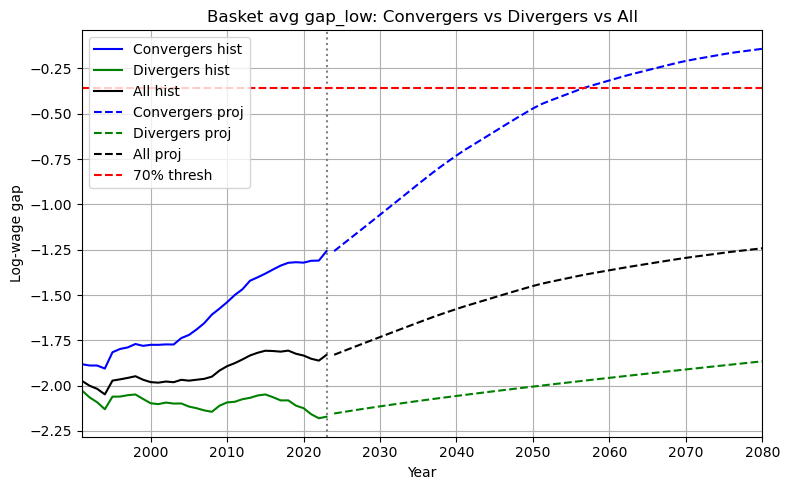

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

# ── 1) helper functions & CV setup ────────────────────────────────────────────
def exp_decay(tc, A, k, C): return A * np.exp(-k*tc) + C
def logistic(tc, L, k, C):  return C + L/(1+np.exp(-k*tc))

tscv = TimeSeriesSplit(n_splits=5)
pipelines = {
    'Linear': LinearRegression(),
    'Quadratic': Pipeline([('poly', PolynomialFeatures(2)),('lr',LinearRegression())]),
    'Sqrt': Pipeline([('sqrt', FunctionTransformer(np.sqrt,validate=False)),('lr',LinearRegression())])
}

# ── 2) load converger & diverger lists ───────────────────────────────────────
conv = pd.read_csv(get_path('Result', 'V30_convergers_low70.csv'))
div  = pd.read_csv(get_path('Result', 'V30_divergers_low70.csv'))
conv_countries = conv['country'].tolist()
div_countries  = div['country'].tolist()
all_countries  = list(set(conv_countries + div_countries))

# ── 3) load wage data & OECD benchmarks ──────────────────────────────────────
df = pd.read_csv(get_path('Result', 'Countries_Wages_Estimates_Finals_GOOD.csv'))

df['log_wage'] = np.log(df['estimated_hourly_wage'])
df['country']  = df['country'].str.replace('\u00A0',' ').str.strip()

bench = pd.read_csv(get_path('Result', 'OECD_benchmark_scenarios.csv')).set_index('year')


# ── 4) prepare non-OECD merged df2 ────────────────────────────────────────────
oecd = {
  'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Rep.','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States','Estonia','Korea','Latvia','Lithuania','Poland'}

df2 = (
    df.merge(bench, on='year', how='left')
      .query("country not in @oecd")
      .dropna(subset=['benchmark_low'])
)

# ── 5) global future-years vector ─────────────────────────────────────────────
years_fut = np.arange(2024, bench.index.max()+1)

# ── 6) function to build low-scenario gaps for any country list ──────────────
def build_low_gaps(country_list):
    low_gaps = {}
    for country in country_list:
        sub = df2[df2['country']==country].sort_values('year')
        if len(sub) < 6: continue

        # history arrays
        y       = sub['year'].values
        t0      = y.min()
        tc_hist = (y - t0).reshape(-1,1)
        lw_hist = sub['log_wage'].values

        # 1) CV to pick best model
        errs = {}
        for name,model in pipelines.items():
            mses=[]
            for tr,te in tscv.split(tc_hist):
                model.fit(tc_hist[tr], lw_hist[tr])
                mses.append(mean_squared_error(lw_hist[te], model.predict(tc_hist[te])))
            errs[name] = np.mean(mses)
        for name,fn in [('ExpDecay',exp_decay),('Logistic',logistic)]:
            mses=[]
            for tr,te in tscv.split(tc_hist):
                Xtr, Ytr = tc_hist[tr].ravel(), lw_hist[tr]
                p0 = [Ytr[0]-Ytr[-1],0.02,Ytr[-1]] if name=='ExpDecay' else [Ytr.max()-Ytr.min(),0.1,Ytr.min()]
                try:
                    p,_ = curve_fit(fn, Xtr, Ytr, p0=p0,
                                    bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
                    preds = fn(tc_hist[te].ravel(), *p)
                    mses.append(mean_squared_error(lw_hist[te], preds))
                except: 
                    mses=[]
                    break
            if mses:
                errs[name] = np.mean(mses)

        # 2) refit best on full history
        best = min(errs, key=errs.get)
        if best in pipelines:
            model = pipelines[best].fit(tc_hist, lw_hist)
            predict = lambda X: model.predict(X)
        else:
            fn = exp_decay if best=='ExpDecay' else logistic
            p0 = [lw_hist[0]-lw_hist[-1],0.02,lw_hist[-1]] if best=='ExpDecay' else [lw_hist.max()-lw_hist.min(),0.1,lw_hist.min()]
            p,_ = curve_fit(fn, tc_hist.ravel(), lw_hist, p0=p0,
                            bounds=([0,0,-np.inf],[np.inf,1,np.inf]), maxfev=10000)
            predict = lambda X,fn=fn,p=p: fn(X.ravel(), *p)

        # 3) last observed gap_low
        hist_bench = np.log( bench.reindex(y)['benchmark_low'].values )
        last_gap   = (lw_hist - hist_bench)[-1]

        # 4) forecast & raw gap_low
        tc_f = (years_fut - t0).reshape(-1,1)
        lw_f = predict(tc_f)
        raw  = lw_f - np.log( bench.reindex(years_fut)['benchmark_low'].values )
        gap_f = np.minimum(raw, 0.0)

        # 5) stitch continuity
        gap_f = gap_f - gap_f[0] + last_gap

        low_gaps[country] = gap_f

    return low_gaps

# ── 7) build projected gaps for each basket ─────────────────────────────────
low_gaps_conv = build_low_gaps(conv_countries)
low_gaps_div  = build_low_gaps(div_countries)
low_gaps_all  = build_low_gaps(all_countries)

# ── 8) turn into DataFrames & compute basket means ─────────────────────────
gap_conv_df = pd.DataFrame(low_gaps_conv, index=years_fut)
gap_div_df  = pd.DataFrame(low_gaps_div,  index=years_fut)
gap_all_df  = pd.DataFrame(low_gaps_all,  index=years_fut)

avg_conv_fut = gap_conv_df.mean(axis=1)
avg_div_fut  = gap_div_df.mean(axis=1)
avg_all_fut  = gap_all_df.mean(axis=1)

# ── 9) compute historical basket averages ───────────────────────────────────
def basket_hist(countries):
    sub = df2[df2['country'].isin(countries)].copy()
    sub['gap_low'] = np.log(sub['estimated_hourly_wage']) - np.log(sub['benchmark_low'])
    return sub.groupby('year')['gap_low'].mean()

hist_conv = basket_hist(conv_countries)
hist_div  = basket_hist(div_countries)
hist_all  = basket_hist(all_countries)

# ── 10) plot all three baskets on one graph ─────────────────────────────────
plt.figure(figsize=(8,5))
plt.plot(hist_conv.index, hist_conv.values, 'b-', label='Convergers hist')
plt.plot(hist_div.index,  hist_div.values,  'g-', label='Divergers hist')
plt.plot(hist_all.index,  hist_all.values,  'k-', label='All hist')

plt.plot(years_fut, avg_conv_fut, 'b--', label='Convergers proj')
plt.plot(years_fut, avg_div_fut,  'g--', label='Divergers proj')
plt.plot(years_fut, avg_all_fut,  'k--', label='All proj')

plt.axvline(2023, color='gray', linestyle=':')
plt.axhline(np.log(0.7), color='red', linestyle='--', label='70% thresh')
plt.xlim(1991, bench.index.max())
plt.xlabel('Year'); plt.ylabel('Log-wage gap')
plt.title('Basket avg gap_low: Convergers vs Divergers vs All')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig(get_path('Result/Plots', 'New_basket_avg_gap_low.pdf'), format='pdf', dpi=300)

plt.show()


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm




# Load data and take logs
df = pd.read_csv(get_path('Result', 'Countries_Wages_Estimates_Finals_GOOD.csv'))

df['log_wage'] = np.log(df['estimated_hourly_wage'])

# ──────────────────────────────────────────────────────────────────────────────
# 1. Sigma Convergence
#    Annual dispersion (standard deviation) of log‐wages
# ──────────────────────────────────────────────────────────────────────────────
sigma_series = df.groupby('year')['log_wage'].std().reset_index(name='sigma')

plt.figure(figsize=(8,4))
plt.plot(
    sigma_series['year'],
    sigma_series['sigma'],
    color='C0',
    linewidth=2,
)
plt.title('Sigma Convergence: Dispersion of Log Wages Over Time', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Std. Dev. of Log Wages', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

sigma_pdf = os.path.join('..', 'Result', 'Plots', 'sigma_convergence_GOOD.pdf')
plt.savefig(sigma_pdf, format='pdf')
plt.close()

# ──────────────────────────────────────────────────────────────────────────────
# 2. Beta Convergence
#    Cross‐sectional regression of annualized growth on initial log wage
# ──────────────────────────────────────────────────────────────────────────────
start, end = df['year'].min(), df['year'].max()
pivot = df.pivot(index='country', columns='year', values='log_wage')
mask = pivot[start].notna() & pivot[end].notna()
pivot = pivot.loc[mask, [start, end]]

growth = (pivot[end] - pivot[start]) / (end - start)
initial = pivot[start]

X = sm.add_constant(initial)
beta_model = sm.OLS(growth, X).fit()

plt.figure(figsize=(8,4))
plt.scatter(
    initial, growth,
    c='C1', edgecolors='white', linewidth=0.8,
    alpha=0.8, s=50
)
x0, x1 = initial.min(), initial.max()
xs = np.linspace(x0, x1, 200)
ys = beta_model.params['const'] + beta_model.params[start] * xs
plt.plot(xs, ys, color='C2', linewidth=2)

plt.title('Beta Convergence: Growth Rate vs Initial Log Wage', fontsize=12)
plt.xlabel(f'Initial Log Wage ({start})', fontsize=10)
plt.ylabel('Annualized Growth Rate of Log Wage', fontsize=10)
plt.text(
    0.05, 0.95,
    f"β = {beta_model.params[start]:.3f}\np = {beta_model.pvalues[start]:.3f}",
    transform=plt.gca().transAxes, verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

beta_pdf = os.path.join('..', 'Result', 'Plots', 'beta_convergence_GOOD.pdf')

plt.savefig(beta_pdf, format='pdf')
plt.close()

print(f"Sigma plot → {sigma_pdf}")
print(f"Beta plot  → {beta_pdf}")


Sigma plot → ../Result/Plots/sigma_convergence_GOOD.pdf
Beta plot  → ../Result/Plots/beta_convergence_GOOD.pdf


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import MaxNLocator

# — CONFIGURE THESE PATHS —
EST_PATH  = get_path('Data', 'Countries_Wages_Estimates_Finals_GOOD.csv')
OECD_PATH = get_path('Data', 'OECD_wages_merged.csv')
OUT_DIR   = get_path('Result', 'Plots')

os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load and prepare
df_est = pd.read_csv(EST_PATH)
df_oecd = pd.read_csv(OECD_PATH)
df_oecd.rename(columns={"Country":"country","Wages":"oecd_annual_wage","Year":"year"}, inplace=True)
df_oecd["year"] = pd.to_numeric(df_oecd["year"], errors="coerce")

df = pd.merge(df_est, df_oecd[["country","year","oecd_annual_wage"]],
              on=["country","year"], how="inner")
df["oecd_hourly_wage"] = df["oecd_annual_wage"] / df["whours"]
df["log_est"] = np.log(df["estimated_hourly_wage"])
df["log_oecd"] = np.log(df["oecd_hourly_wage"])

# 2) Split countries in two halves
countries = sorted(df["country"].dropna().unique())
half = len(countries)//2
batches = [countries[:half], countries[half:]]

from matplotlib.ticker import MultipleLocator

# 3) For each half, make a PDF with independent axes and 5-year ticks
for part, subset in enumerate(batches, start=1):
    n = len(subset)
    cols, rows = 3, math.ceil(n/3)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows),
                             sharex=False, sharey=False)
    axes = axes.flatten()
    
    for i, country in enumerate(subset):
        ax = axes[i]
        d = df[df["country"] == country].sort_values("year")
        
        # plot estimate vs. OECD
        ax.plot(d["year"], d["log_est"], label="Estimate", color=plt.cm.Set1(0))
        ax.plot(d["year"], d["log_oecd"], label="OECD",    color=plt.cm.Set1(1))
        
        # set ticks every 5 years
        start, end = d["year"].min(), d["year"].max()
        ax.set_xticks(np.arange(start - (start % 5), end + 1, 5))
        ax.xaxis.set_major_locator(MultipleLocator(5))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        ax.set_title(country, fontsize=12)
        ax.set_xlabel("Year")
        ax.set_ylabel("Log Hourly Wage")
        ax.grid(True, ls='--', alpha=0.6)
        if i == 0:
            ax.legend()
        
        # add 10% vertical padding
        y0, y1 = ax.get_ylim()
        dy = (y1 - y0) * 0.1
        ax.set_ylim(y0 - dy, y1 + dy)
    
    # hide any unused subplots
    for j in range(n, len(axes)):
        axes[j].set_visible(False)
    
    # adjust spacing 
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

    
    # save
    out_pdf = os.path.join(OUT_DIR, f"wage_comparison_part{part}.pdf")
    fig.savefig(out_pdf, dpi=300)
    plt.close(fig)
    print(f"Saved {out_pdf}")




Saved ../Result/Plots/wage_comparison_part1.pdf
Saved ../Result/Plots/wage_comparison_part2.pdf


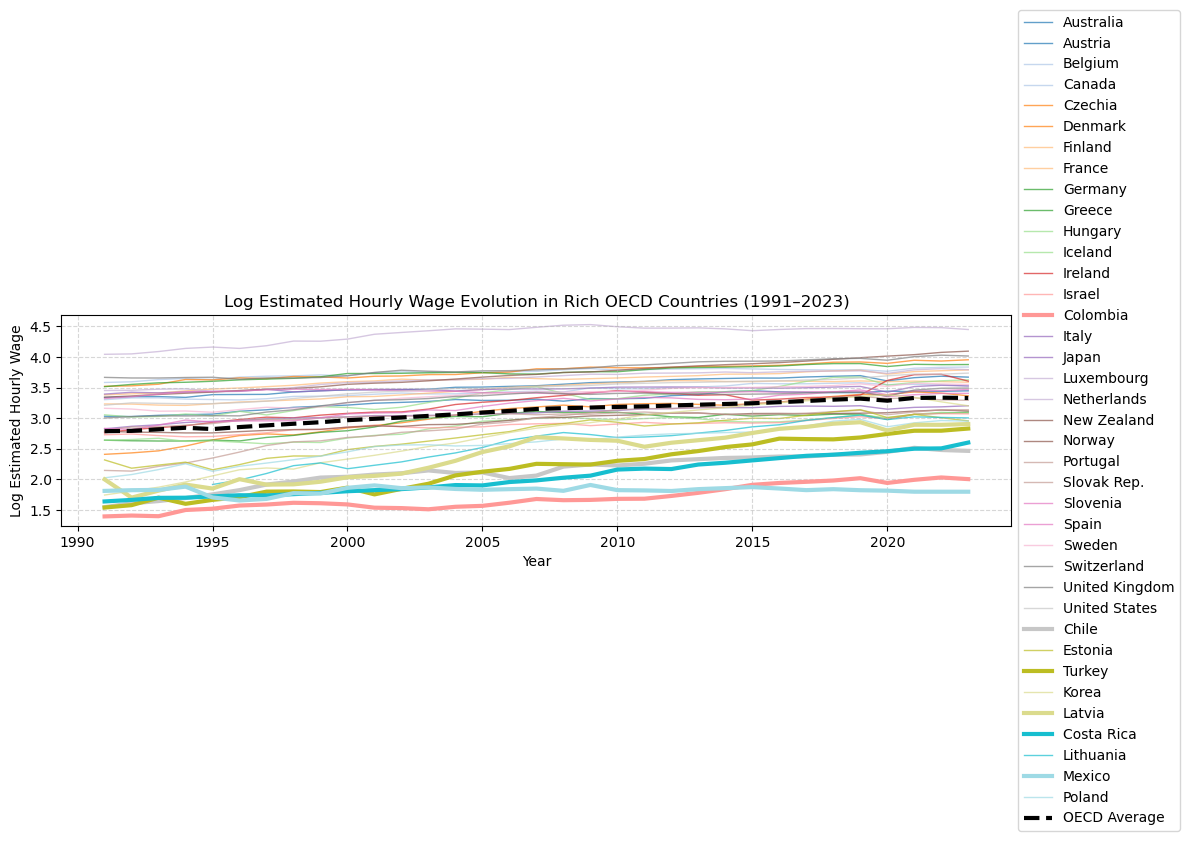

Saved plot to ../Result/Plots/OECD_log_wage_evolution_highlighted.pdf


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your estimated hourly-wage data

df_est = pd.read_csv(EST_PATH)

# 2) Define the OECD benchmark group (raw list)
oecd_countries = [
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Colombia','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Rep.','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States','Chile','Estonia','Turkey','Korea','Latvia','Costa Rica','Lithuania','Mexico','Poland'
]

# 3) Compute log of your estimated hourly wage
df_est['log_est'] = np.log(df_est['estimated_hourly_wage'])

# 4) Normalize df_est['country'] to replace NBSPs and trim
df_est['country'] = (
    df_est['country']
      .str.replace('\u00A0', ' ')  # NBSP → normal space
      .str.strip()
)

# 5) Normalize the OECD list the same way
oecd_countries = [c.replace('\u00A0', ' ').strip() for c in oecd_countries]

# 6) Keep only OECD countries and pivot to wide form (years × countries)
df_oecd = df_est[df_est['country'].isin(oecd_countries)]
pivot = df_oecd.pivot(index='year', columns='country', values='log_est').sort_index()

# 7) Compute the OECD-average log wage each year
pivot['OECD Average'] = pivot.mean(axis=1)

# 8) Plot all country lines plus the average, highlighting a few
plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(oecd_countries)))

for country, color in zip(oecd_countries, colors):
    if country not in pivot.columns:
        continue
    # Thicker, fully opaque lines for Chile & Estonia & Colombia
    if country in ['Chile', 'Colombia', 'Costa Rica', 'Mexico', 'Turkey','Latvia']:
        lw, alpha, z = 3.0, 1.0, 4
    else:
        lw, alpha, z = 1.0, 0.7, 1
    plt.plot(pivot.index, pivot[country],
             label=country, color=color,
             linewidth=lw, alpha=alpha, zorder=z)

# Bold dashed line for the OECD average
plt.plot(pivot.index, pivot['OECD Average'],
         label='OECD Average', color='k',
         linewidth=3, linestyle='--', zorder=5)

plt.xlabel('Year')
plt.ylabel('Log Estimated Hourly Wage')
plt.title('Log Estimated Hourly Wage Evolution in Rich OECD Countries (1991–2023)')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# 9) Save to PDF
# Define output directory and file path using relative paths
OUT_DIR = os.path.join('..', 'Result', 'Plots')
os.makedirs(OUT_DIR, exist_ok=True)

out_pdf = os.path.join(OUT_DIR, 'OECD_log_wage_evolution_highlighted.pdf')
plt.savefig(out_pdf, dpi=300)
plt.show()

print(f"Saved plot to {out_pdf}")


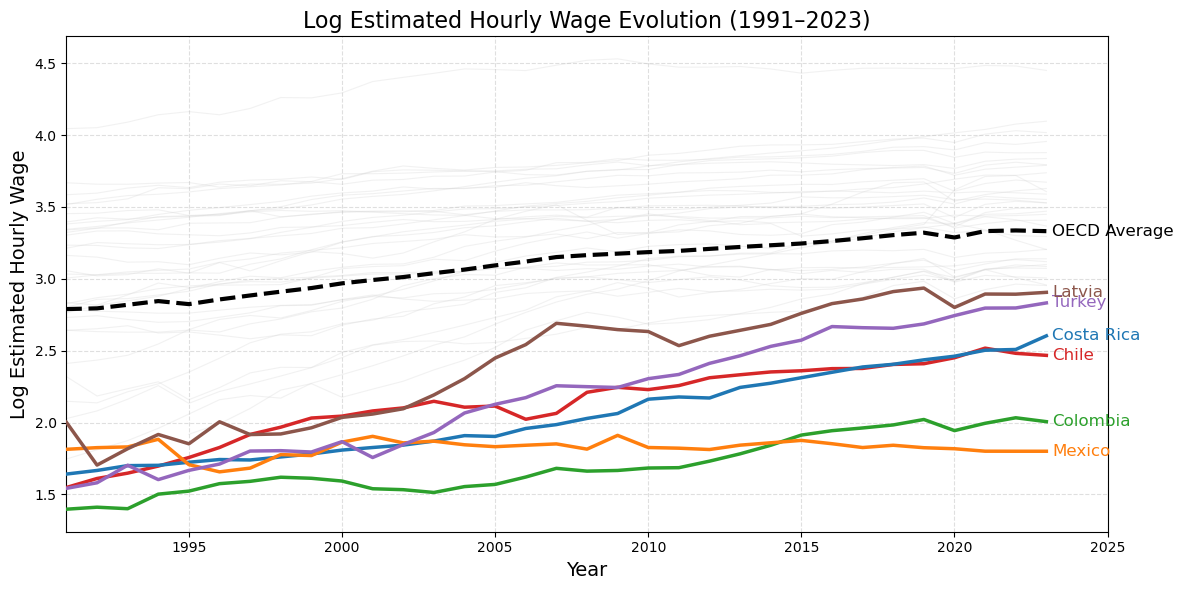

Saved plot to ../Result/Plots/OECD_log_wage_evolution_highlighted_v2.pdf


In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your estimated hourly-wage data
EST_PATH = os.path.join('..', 'Data', 'Countries_Wages_Estimates_Finals_GOOD.csv')
df = pd.read_csv(EST_PATH)

# 2) Define OECD countries
oecd_countries = [
    'Australia','Austria','Belgium','Canada','Czechia','Denmark','Finland','France','Germany',
    'Greece','Hungary','Iceland','Ireland','Israel','Colombia','Italy','Japan','Luxembourg','Netherlands',
    'New Zealand','Norway','Portugal','Slovak Rep.','Slovenia','Spain','Sweden','Switzerland',
    'United Kingdom','United States','Chile','Estonia','Turkey','Korea','Latvia','Costa Rica','Lithuania','Mexico','Poland'
]

# 3) Compute log-wage
df['log_est'] = np.log(df['estimated_hourly_wage'])

# 4) Filter & pivot
df_oecd = df[df['country'].isin(oecd_countries)]
pivot = df_oecd.pivot(index='year', columns='country', values='log_est').sort_index()

# 5) OECD average
pivot['OECD Average'] = pivot.mean(axis=1)

# 6) Plot
plt.figure(figsize=(12,6))

# a) Background: all countries in faint grey
for country in pivot.columns.drop('OECD Average'):
    plt.plot(pivot.index, pivot[country],
             color='lightgrey', linewidth=0.8, alpha=0.3, zorder=1)

# b) Highlighted countries
highlight = ['Chile','Colombia','Costa Rica','Mexico','Turkey','Latvia']
highlight_colors = {
    'Chile'     : '#d62728',
    'Colombia'  : '#2ca02c',
    'Costa Rica': '#1f77b4',
    'Mexico'    : '#ff7f0e',
    'Turkey'    : '#9467bd',
    'Latvia'    : '#8c564b'
}

for c in highlight:
    if c in pivot:
        plt.plot(pivot.index, pivot[c],
                 color=highlight_colors[c],
                 linewidth=2.5,
                 alpha=1.0,
                 zorder=3)

# c) OECD average in bold dashed black
plt.plot(pivot.index, pivot['OECD Average'],
         color='black',
         linewidth=3.0,
         linestyle='--',
         zorder=4)

# d) Direct‐label at 2023
for name, colo in list(highlight_colors.items()) + [('OECD Average','black')]:
    if name not in pivot: 
        continue
    y2023 = pivot[name].loc[2023]
    plt.text(2023.2, y2023, name,
             color=colo,
             va='center',
             fontsize=12)

# 7) Polish
plt.xlim(pivot.index.min(), 2025)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Log Estimated Hourly Wage', fontsize=14)
plt.title('Log Estimated Hourly Wage Evolution (1991–2023)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# 8) Save
OUT_DIR = os.path.join('..', 'Result', 'Plots')
os.makedirs(OUT_DIR, exist_ok=True)

out_pdf = os.path.join(OUT_DIR, 'OECD_log_wage_evolution_highlighted_v2.pdf')
plt.savefig(out_pdf, dpi=300)
plt.show()

print(f"Saved plot to {out_pdf}")


In [23]:
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore



# --- A) Compute each country’s long-run average level wage ---
avg_log = pivot.mean().drop('OECD Average')  # country mean of log-wages
avg_lvl = np.exp(avg_log)                    # back to levels

# 1) grand mean & SD of those average levels
mu    = avg_lvl.mean()
sigma = avg_lvl.std()

# --- B) Classify by the 1σ rule ---
sd_threshold = mu - sigma
oecd_poor_sd  = avg_lvl[avg_lvl < sd_threshold].index.tolist()
oecd_rich_sd  = avg_lvl[avg_lvl >= sd_threshold].index.tolist()

# --- C) Build enriched summary table ---
summary = pd.DataFrame({
    'avg_level_wage': avg_lvl,
    'flag_poor_sd':   avg_lvl < sd_threshold
})

# z-score relative to the cross-country distribution
summary['z_score'] = (summary['avg_level_wage'] - mu) / sigma

# percent-gap vs grand mean
summary['gap_vs_mean_%'] = (mu - summary['avg_level_wage']) / mu * 100

# percentile rank among all OECD long-run averages
summary['percentile_rank_%'] = summary['avg_level_wage'].apply(
    lambda x: percentileofscore(avg_lvl, x)
)

# sort for readability
summary = summary.sort_values('avg_level_wage')

# --- D) Output results ---
print(f"Grand mean level wage: {mu:.2f}")
print(f"1 σ below mean        : {sd_threshold:.2f}\n")

print("OECD-poor under 1 σ rule:", oecd_poor_sd, "\n")
print("Full diagnostics table:\n", summary)


Grand mean level wage: 25.90
1 σ below mean        : 11.48

OECD-poor under 1 σ rule: ['Chile', 'Colombia', 'Costa Rica', 'Latvia', 'Mexico', 'Turkey'] 

Full diagnostics table:
                 avg_level_wage  flag_poor_sd   z_score  gap_vs_mean_%  \
country                                                                 
Colombia              5.470814          True -1.416753      78.879264   
Mexico                6.185782          True -1.367177      76.119048   
Costa Rica            7.766058          True -1.257600      70.018199   
Chile                 8.457942          True -1.209624      67.347099   
Turkey                8.909711          True -1.178298      65.602990   
Latvia               11.177098          True -1.021076      56.849470   
Poland               13.289805         False -0.874579      48.693114   
Lithuania            13.663054         False -0.848698      47.252141   
Estonia              15.133436         False -0.746740      41.575553   
Korea             

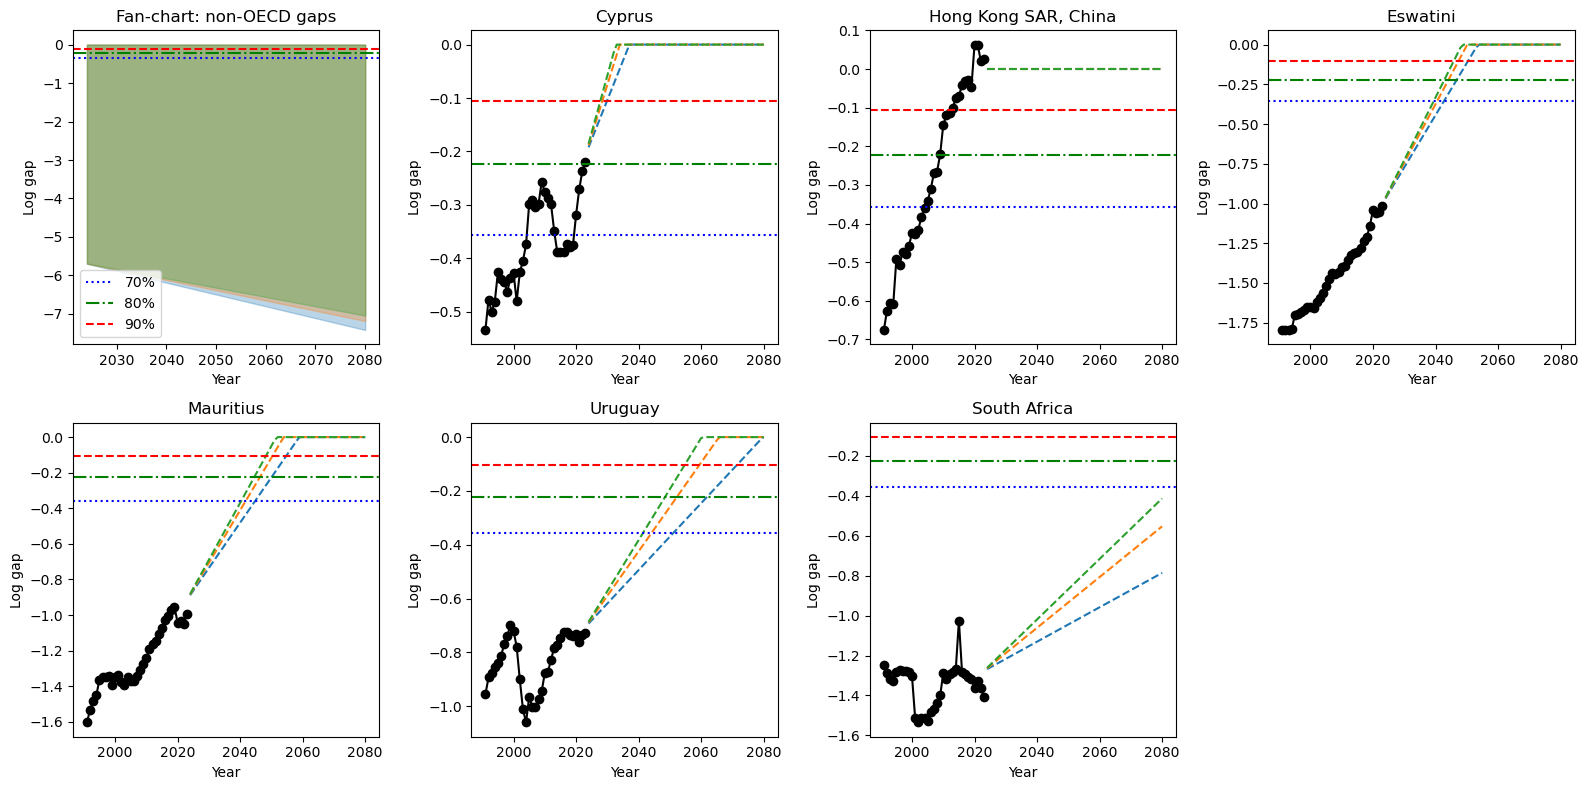

Written combined panels to ../Result/Plots/combined_6countries_plus_fanchart.pdf


In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

# ── INPUTS ─────────────────────────────────────────────────────────────────────

EST_CSV     = os.path.join('..', 'Data',    'Countries_Wages_Estimates_Finals_GOOD.csv')
BENCH_CSV   = os.path.join('..', 'Data',    'OECD_benchmark_scenarios.csv')
SUMMARY_CSV = os.path.join('..', 'Result',  'V30_convergence_three_scenarios_nonOECD_plateau_summary.csv')
OUT_PDF     = os.path.join('..', 'Result',  'Plots', 'combined_6countries_plus_fanchart.pdf')


# ── LOAD DATA ───────────────────────────────────────────────────────────────────
df = pd.read_csv(EST_CSV)
df['log_wage'] = np.log(df['estimated_hourly_wage'])
df['country'] = df['country'].str.replace('\u00A0',' ').str.strip()
bench = pd.read_csv(BENCH_CSV)
res   = pd.read_csv(SUMMARY_CSV)

# build non-OECD sample
oecd = {...}  # same set as before
df2 = (df.merge(bench, on='year', how='left')
         .query("country not in @oecd")
         .dropna(subset=['benchmark_high']))

# common histogram end and forecast horizon
H_END = df2['year'].max()                  # e.g. 2023
F_YEARS = np.arange(H_END+1, bench['year'].max()+1)

# pick six examples
res['L-70_num'] = pd.to_numeric(res['L-70'], errors='coerce')
fast  = res.dropna(subset=['L-70_num']).nsmallest(2,'L-70_num')['country'].tolist()
mids  = res.dropna(subset=['L-70_num']).sort_values('L-70_num')
midx  = len(mids)//2
mid   = mids.iloc[midx-1:midx+1]['country'].tolist()
never = res[res['L-70_num'].isna()].nlargest(2,'gap_low_2080')['country'].tolist()
selected = fast + mid + never

# ── REFIT & COLLECT GAPS ────────────────────────────────────────────────────────
def get_gaps(sub):
    # fit linear trend on (year-H_END) even if shorter history
    tc = (sub['year'] - sub['year'].min()).values.reshape(-1,1)
    y  = sub['log_wage'].values
    m  = LinearRegression().fit(tc, y)
    # hist gaps
    gh = y - np.log(sub['benchmark_high'].values)
    # forecast on common horizon
    tc_f = (F_YEARS - sub['year'].min()).reshape(-1,1)
    yf   = m.predict(tc_f)
    gaps = {}
    for s in ['high','medium','low']:
        bench_vals = bench.set_index('year')[f'benchmark_{s}'].reindex(F_YEARS).values
        raw = yf - np.log(bench_vals)
        gaps[s] = np.minimum(raw, 0.0)
    return sub['year'].values, gh, F_YEARS, gaps

# all non-OECD for fan
gaps_all = {c: get_gaps(df2[df2['country']==c]) for c in df2['country'].unique()}

# ensure selected are in gaps_all
for c in selected:
    if c not in gaps_all:
        gaps_all[c] = get_gaps(df2[df2['country']==c])

# ── PLOT 2×4 ────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2,4, figsize=(16,8))
ax_fan = axes[0,0]
others = axes.flatten()[1:7]

# fan‐chart
years_hist, _, years_fut, _ = gaps_all[next(iter(gaps_all))]
for scen,col in zip(['high','medium','low'],['C0','C1','C2']):
    M = np.vstack([g[3][scen] for g in gaps_all.values()])
    ax_fan.fill_between(years_fut, M.min(0), M.max(0), color=col, alpha=0.3)
for lvl,ls,col in [(0.7,':','blue'),(0.8,'-.','green'),(0.9,'--','red')]:
    ax_fan.axhline(np.log(lvl), ls=ls, color=col, label=f"{int(lvl*100)}%")
ax_fan.set_title("Fan‐chart: non‐OECD gaps"); ax_fan.set_xlabel("Year"); ax_fan.set_ylabel("Log gap")
ax_fan.legend()

# country panels
for ax,c in zip(others, selected):
    yh, gh, yf, gf = gaps_all[c]
    ax.plot(yh, gh, 'k-o')
    for scen,col in zip(['high','medium','low'],['C0','C1','C2']):
        ax.plot(yf, gf[scen], '--', color=col)
    for lvl,ls,col in [(0.7,':','blue'),(0.8,'-.','green'),(0.9,'--','red')]:
        ax.axhline(np.log(lvl), ls=ls, color=col)
    ax.set_title(c); ax.set_xlabel("Year"); ax.set_ylabel("Log gap")

axes[1,3].set_visible(False)
plt.tight_layout()
plt.savefig(OUT_PDF, dpi=300)
plt.show()

print("Written combined panels to", OUT_PDF)


In [27]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# — configure paths —
EST_PATH  = os.path.join('..', 'Data',   'Countries_Wages_Estimates_Finals_GOOD.csv')
OECD_PATH = os.path.join('..', 'Data',   'OECD_wages_merged.csv')
OUT_DIR   = os.path.join('..', 'Result', 'Plots')
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load and prepare data
df_est = pd.read_csv(EST_PATH)
df_oecd = pd.read_csv(OECD_PATH).rename(
    columns={"Country":"country","Year":"year","Wages":"oecd_annual_wage"})
df_oecd['year'] = pd.to_numeric(df_oecd['year'], errors='coerce')

df = pd.merge(df_est, df_oecd[['country','year','oecd_annual_wage']],
              on=['country','year'], how='inner')
df['oecd_hourly'] = df['oecd_annual_wage'] / df['whours']
df['log_est'] = np.log(df['estimated_hourly_wage'])
df['log_oecd'] = np.log(df['oecd_hourly'])
df['gap'] = df['log_oecd'] - df['log_est']

# 2) Split countries into two halves for small multiples
countries = sorted(df['country'].unique())
half = len(countries)//2
batches = [countries[:half], countries[half:]]

# 3) For each half, make subplots with ±1.96σ band around the TRUE OECD series
for part, subset in enumerate(batches, start=1):
    n = len(subset)
    cols, rows = 3, math.ceil(n/3)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    axes = axes.flatten()
    
    for i, country in enumerate(subset):
        ax = axes[i]
        d = df[df['country'] == country].sort_values('year')
        
        # compute in-sample sigma of gap
        sigma = d['gap'].std()
        lower = d['log_oecd'] - 1.96*sigma
        upper = d['log_oecd'] + 1.96*sigma
        
        # shade band around true OECD
        ax.fill_between(d['year'], lower, upper, color='lightgrey', alpha=0.5)
        
        # plot true OECD wage
        ax.plot(d['year'], d['log_oecd'], label='True OECD', color='tab:blue', linewidth=2)
        # plot estimated wage
        ax.plot(d['year'], d['log_est'],  label='Estimate',    color='tab:red',  linewidth=1)
        
        # highlight thicker
        if country in ['Chile', 'Colombia', 'Costa Rica', 'Mexico', 'Turkey','Latvia']:
            for line in ax.get_lines():
                line.set_linewidth(3)
        
        # x-axis ticks every 5 years
        ax.xaxis.set_major_locator(MultipleLocator(5))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        ax.set_title(country)
        ax.set_xlabel('Year')
        ax.set_ylabel('Log Hourly Wage')
        ax.grid(True, ls='--', alpha=0.6)
        if i == 0:
            ax.legend(loc='upper left', fontsize='small')
        
        # add vertical padding
        y0, y1 = ax.get_ylim()
        dy = (y1-y0)*0.1
        ax.set_ylim(y0-dy, y1+dy)
    
    # hide unused axes
    for j in range(n, len(axes)):
        axes[j].set_visible(False)
    
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    out_pdf = os.path.join(OUT_DIR, f'wage_compare_band_part{part}.pdf')
    fig.savefig(out_pdf, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved {out_pdf}")
    # after your merge & gap calc…
present = sorted(df['country'].dropna().unique())
print("Countries in the output:", present)




Saved ../Result/Plots/wage_compare_band_part1.pdf
Saved ../Result/Plots/wage_compare_band_part2.pdf
Countries in the output: ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovak Rep.', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'United Kingdom', 'United States']
